In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision 
import torch
from torch.utils.data import (Dataset, DataLoader)  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torchvision.models as models
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [12]:
!kaggle datasets download -d alessiocorrado99/animals10 --force


100% 585M/586M [00:08<00:00, 90.5MB/s]
100% 586M/586M [00:08<00:00, 69.6MB/s]


In [32]:
!unzip "/content/drive/My Drive/animals10.zip" -d "/content/drive/My Drive/Animals" 


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/drive/My Drive/Animals/raw-img/ragno/OIP-MgCgailkT5XkO

(200, 300)


list

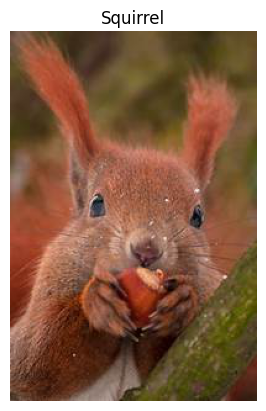

In [19]:
import os
import cv2
import glob
import pathlib
# data_dir = pathlib.Path('/content/drive/My Drive/Wildlife/oregon_wildlife/oregon_wildlife/')
data = glob.glob('/content/drive/My Drive/Animals/raw-img/squirrel/*.jpeg')
img = tf.keras.preprocessing.image.load_img(data[0])
d = os.listdir('/content/drive/My Drive/Animals/raw-img/')
im = Image.open((data[0]))
print(im.size)
resized_image = tf.image.resize(im, [224, 224]) # specify desired height and width

plt.imshow(im)
plt.axis('off')
plt.title('Squirrel')
type(data)

In [34]:
dir = '/content/drive/My Drive/Animals/raw-img/'
# files = [f for f in glob.glob(dir + "**/**", recursive=True)] # create a list will allabsolute path of all files
# len(files)
eng_labels = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno":"spider", "scoiattolo": "squirrel"}
(eng_labels.values())

dict_values(['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel'])

In [33]:
for orig_name, new_name in eng_labels.items():
    os.rename('/content/drive/My Drive/Animals/raw-img/'+orig_name, '/content/drive/My Drive/Animals/raw-img/'+new_name)

In [35]:
batch_size = 32
img_height = 224
img_width = 224

In [36]:
train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, zoom_range=0.1, rotation_range=0.1, horizontal_flip=True,validation_split=0.3
)

train_datagen = train_image_data_generator.flow_from_directory(
    dir, batch_size=batch_size, class_mode="categorical", target_size=(img_width, img_height),subset='training'
)




Found 18331 images belonging to 10 classes.


In [37]:
# train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1.0 / 255, zoom_range=0.1, rotation_range=0.1, horizontal_flip=True,validation_split=0.
# )
test_datagen =train_image_data_generator.flow_from_directory(
    dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 7848 images belonging to 10 classes.


In [22]:
class_names = list(train_datagen.class_indices.keys())
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


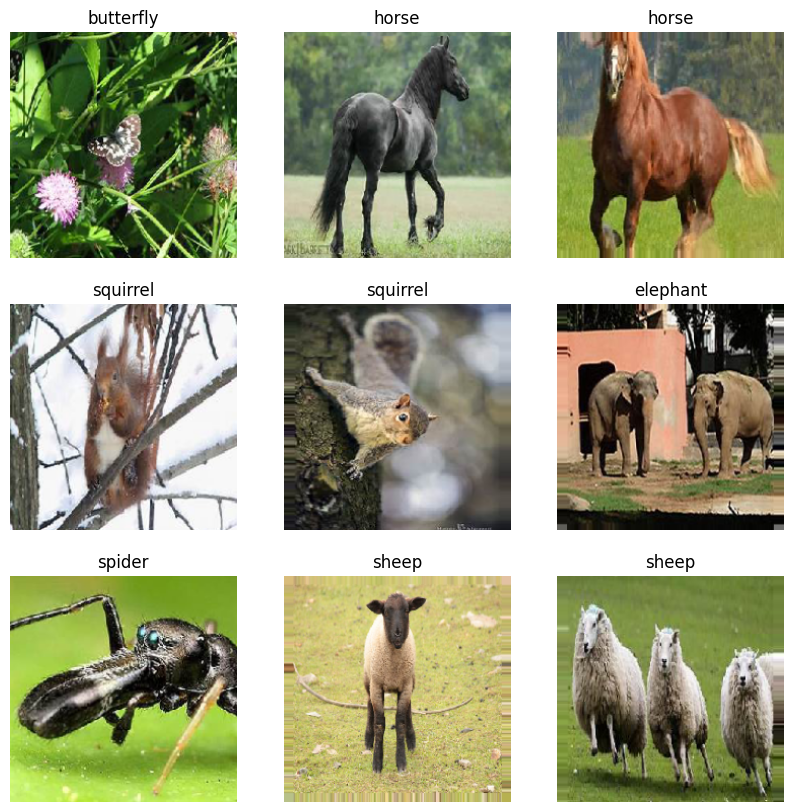

In [23]:
images, labels = train_datagen.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

Now let us clean the **data**

In [24]:
IMG_SHAPE = (224,224) + (3,)

new_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
for layer in new_model.layers:
    layer.trainable = False


In [26]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = new_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x= layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
# x= layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.01
sgd = SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 40,935,754
Trainable params: 26,221,066
Non-tra

In [38]:
history1 = model.fit(train_datagen,
                      epochs=2,
                    validation_data=test_datagen)

Epoch 1/2
573/573 [==============================] - 431s 752ms/step - loss: 0.4872 - accuracy: 0.8345 - val_loss: 0.5093 - val_accuracy: 0.8393
Epoch 2/2
573/573 [==============================] - 398s 694ms/step - loss: 0.3984 - accuracy: 0.8671 - val_loss: 0.4956 - val_accuracy: 0.8405


In [39]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_datagen)

246/246 [==============================] - 115s 466ms/step - loss: 0.4946 - accuracy: 0.8439


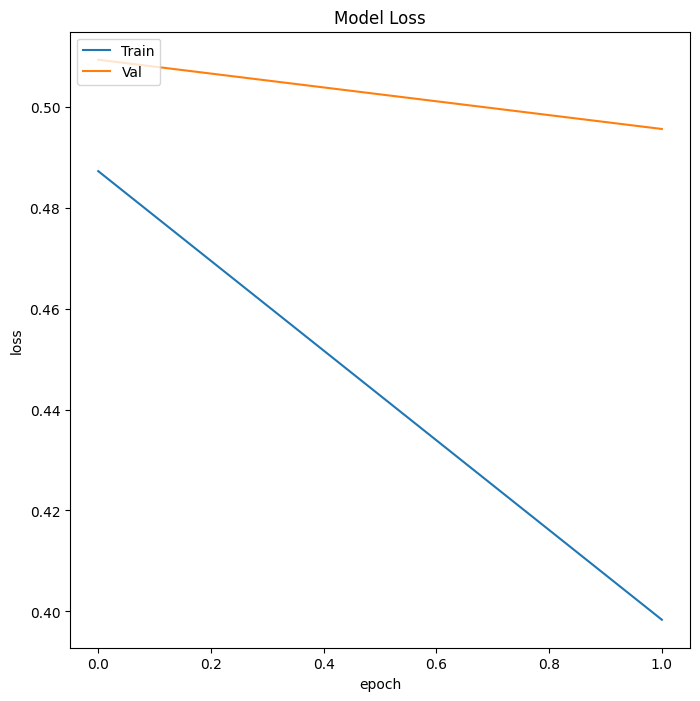

In [45]:
plt.figure(figsize=(8,8))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

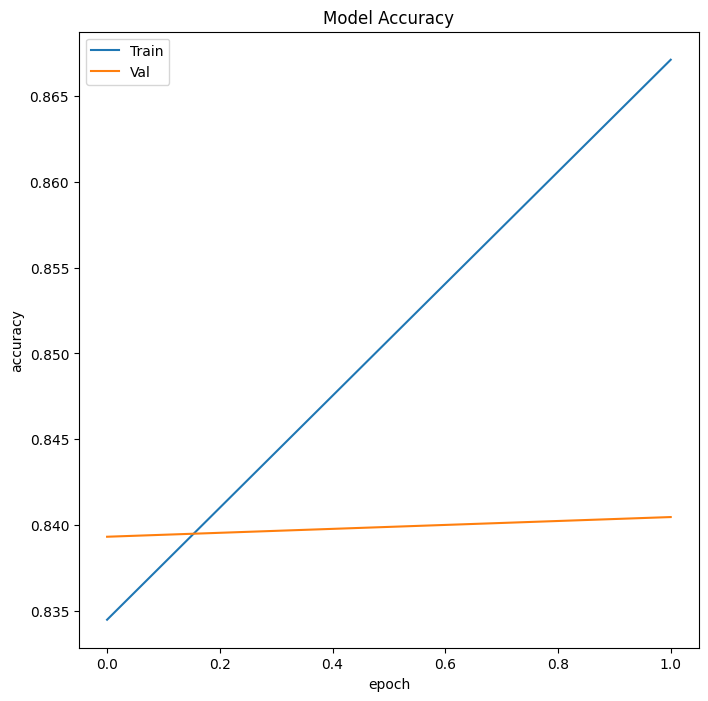

In [44]:
plt.figure(figsize=(8,8))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [49]:
y_test = test_datagen.classes
y_pred = model.predict(test_datagen)
y_pred_probs = y_pred.copy()

246/246 [==============================] - 118s 478ms/step


In [65]:
images, labels = train_datagen.next()

y_test

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_int = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test,y_pred_int,target_names = eng_labels))


              precision    recall  f1-score   support

        cane       0.07      0.07      0.07       633
     cavallo       0.06      0.08      0.07       500
    elefante       0.10      0.09      0.09       929
    farfalla       0.08      0.08      0.08       559
     gallina       0.19      0.18      0.19      1458
       gatto       0.06      0.06      0.06       433
       mucca       0.11      0.12      0.11       786
      pecora       0.06      0.05      0.06       546
       ragno       0.18      0.18      0.18      1446
  scoiattolo       0.07      0.08      0.07       558

    accuracy                           0.12      7848
   macro avg       0.10      0.10      0.10      7848
weighted avg       0.12      0.12      0.12      7848

